In [67]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

In [83]:
df = pd.read_csv('./data/fire_data.csv')

In [84]:
def get_geojson_grid(upper_right, lower_left, n=6):

    all_boxes = []

    lat_steps = np.linspace(lower_left[0], upper_right[0], n+1)
    lon_steps = np.linspace(lower_left[1], upper_right[1], n+1)

    lat_stride = lat_steps[1] - lat_steps[0]
    lon_stride = lon_steps[1] - lon_steps[0]

    for lat in lat_steps[:-1]:
        for lon in lon_steps[:-1]:
            # Define dimensions of box in grid
            upper_left = [lon, lat + lat_stride]
            upper_right = [lon + lon_stride, lat + lat_stride]
            lower_right = [lon + lon_stride, lat]
            lower_left = [lon, lat]

            # Define json coordinates for polygon
            coordinates = [
                upper_left,
                upper_right,
                lower_right,
                lower_left,
                upper_left
            ]

            geo_json = {"type": "FeatureCollection",
                        "properties":{
                            "lower_left": lower_left,
                            "upper_right": upper_right
                        },
                        "features":[]}

            grid_feature = {
                "type":"Feature",
                "geometry":{
                    "type":"Polygon",
                    "coordinates": [coordinates],
                }
            }

            geo_json["features"].append(grid_feature)

            all_boxes.append(geo_json)

    return all_boxes

In [85]:
LOWER = 36.0721
LEFT = 126.6796
UPPER = 36.3865
RIGHT = 127.07

In [86]:
df_clean = df.loc[:, ["화재발생년월일", "대상(도로)명", "최종_경도", "최종_위도"]]
df_clean = df_clean.drop(df_clean[df_clean['최종_경도'] == 0].index)
df_clean = df_clean.drop(df_clean[df_clean['최종_경도'] < LEFT].index)
df_clean = df_clean.drop(df_clean[df_clean['최종_경도'] > RIGHT].index)
df_clean = df_clean.drop(df_clean[df_clean['최종_위도'] < LOWER].index)
df_clean = df_clean.drop(df_clean[(df_clean['최종_위도'] > UPPER)].index)
df_clean.reset_index(inplace=True)

In [87]:
df_clean.head()

,index,화재발생년월일,대상(도로)명,최종_경도,최종_위도
0,0,2012-01-02 10:23,동식물시설(견사),126.892854,36.182266
1,1,2012-01-02 19:58,건축구조물(단독주택),126.906522,36.283769
2,2,2012-01-03 17:40,위락시설-유흥주점(베네치아),126.870201,36.273447
3,3,2012-01-04 22:59,주거시설-단독주택,126.885429,36.157451
4,4,2012-01-06 0:57,주거시설-단독주택,126.862228,36.190490


In [104]:
df_clean['x'] = df_clean['최종_경도'].astype(float).map(lambda x: np.trunc((x - LEFT) / ((RIGHT - LEFT) / 15.)))
df_clean['y'] = df_clean['최종_위도'].astype(float).map(lambda x: np.trunc((x - LOWER) / ((UPPER - LOWER) / 15.)))

In [105]:
df_clean.head()

,index,화재발생년월일,대상(도로)명,최종_경도,최종_위도,x,y
0,0,2012-01-02 10:23,동식물시설(견사),126.892854,36.182266,8.0,5.0
1,1,2012-01-02 19:58,건축구조물(단독주택),126.906522,36.283769,8.0,10.0
2,2,2012-01-03 17:40,위락시설-유흥주점(베네치아),126.870201,36.273447,7.0,9.0
3,3,2012-01-04 22:59,주거시설-단독주택,126.885429,36.157451,7.0,4.0
4,4,2012-01-06 0:57,주거시설-단독주택,126.862228,36.190490,7.0,5.0


In [107]:
pd.to_datetime(df_clean['화재발생년월일']).dt.

0       10
1       19
2       17
3       22
4        0
        ..
1594    20
1595    12
1596    11
1597    16
1598    19
Name: 화재발생년월일, Length: 1599, dtype: int64

In [88]:
df_lat_lon = df_clean.loc[:, ["최종_위도","최종_경도"]]

In [89]:
m = folium.Map(location=((LOWER + UPPER) / 2, (LEFT + RIGHT) / 2), zoom_start=10)

upper_right = [UPPER, RIGHT]
lower_left = [LOWER, LEFT]

grid = get_geojson_grid(upper_right, lower_left , n=15)

for i, geo_json in enumerate(grid):

    color = plt.cm.Reds(1)
    color = mpl.colors.to_hex(color)

    gj = folium.GeoJson(geo_json,
                        style_function=lambda feature, color=color: {
                                                                        'fillColor': color,
                                                                        'color':"black",
                                                                        'weight': 2,                                                                      
                                                                        'fillOpacity': 0.3,
                                                                    })
    popup = folium.Popup("example popup {}".format(i))
    gj.add_child(popup)

    m.add_child(gj)

for i in range(len(df_lat_lon)):
    folium.Circle([df_lat_lon.loc[i, "최종_위도"], df_lat_lon.loc[i, "최종_경도"]], ).add_to(m)

m

In [101]:
fire_heatmap = df_clean.loc[:, ['y', 'x']].groupby(['y', 'x'])['x'].count().unstack().sort_index(ascending=False).fillna(0)
fire_heatmap

x,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
y,,,,,,,,,,,,,,,
14.0,0.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13.0,0.0,3.0,4.0,0.0,1.0,7.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12.0,0.0,11.0,4.0,2.0,4.0,10.0,12.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0
11.0,5.0,10.0,2.0,1.0,2.0,6.0,27.0,13.0,8.0,7.0,28.0,7.0,0.0,0.0,0.0
10.0,5.0,9.0,10.0,11.0,1.0,7.0,23.0,13.0,39.0,58.0,34.0,2.0,7.0,4.0,0.0
9.0,0.0,3.0,7.0,3.0,8.0,13.0,32.0,59.0,75.0,56.0,26.0,13.0,21.0,29.0,15.0
8.0,0.0,0.0,4.0,12.0,20.0,25.0,25.0,18.0,16.0,10.0,6.0,8.0,29.0,26.0,0.0
7.0,0.0,5.0,7.0,21.0,35.0,20.0,18.0,14.0,5.0,9.0,8.0,15.0,13.0,6.0,0.0
6.0,0.0,11.0,23.0,29.0,15.0,12.0,7.0,5.0,6.0,6.0,8.0,10.0,2.0,0.0,0.0


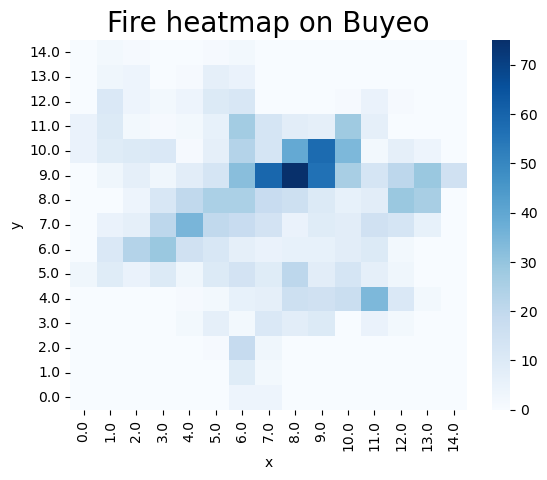

In [102]:
ax = sns.heatmap(fire_heatmap, cmap='Blues')
plt.title('Fire heatmap on Buyeo', fontsize=20)
plt.show()

In [138]:
df_clean[df_clean["대상(도로)명"].astype(str).map(lambda x: "임야" in x)]

,index,화재발생년월일,대상(도로)명,최종_경도,최종_위도,x,y
25,27,2012-02-12 14:44,임야,126.887495,36.245604,7.0,8.0
48,55,2012-03-27 13:19,임야,126.767360,36.295739,3.0,10.0
53,61,2012-04-08 10:37,임야,126.855586,36.085146,6.0,0.0
54,63,2012-04-15 14:16,임야,126.822394,36.236974,5.0,7.0
62,72,2012-04-30 14:27,임야,126.972710,36.260413,11.0,8.0
...,...,...,...,...,...,...,...
1534,1587,2022-05-05 13:54,임야(둑방),126.827450,36.358403,5.0,13.0
1546,1599,2022-06-13 22:11,임야(밤나무밭),126.853527,36.326206,6.0,12.0
1561,1614,2022-09-15 11:22,임야(밭),126.770074,36.288107,3.0,10.0
1562,1615,2022-09-21 15:58,임야(산),126.839305,36.199786,6.0,6.0


<AxesSubplot:>

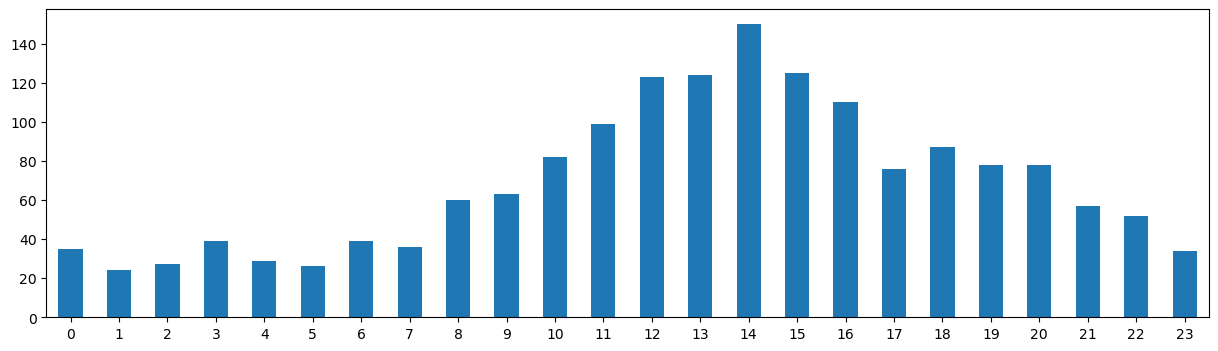

In [6]:
df_date = df.loc[:, "화재발생년월일"].dropna()
pd.to_datetime(df_date).dt.hour.value_counts().sort_index().plot.bar(figsize=(15, 4), rot=0)

<AxesSubplot:>

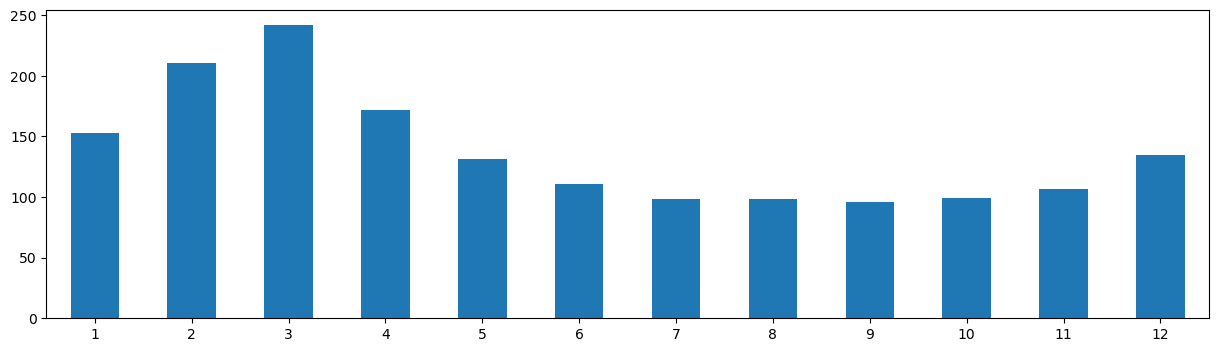

In [81]:
pd.to_datetime(df_date).dt.month.value_counts().sort_index().plot.bar(figsize=(15, 4), rot=0)

<AxesSubplot:>

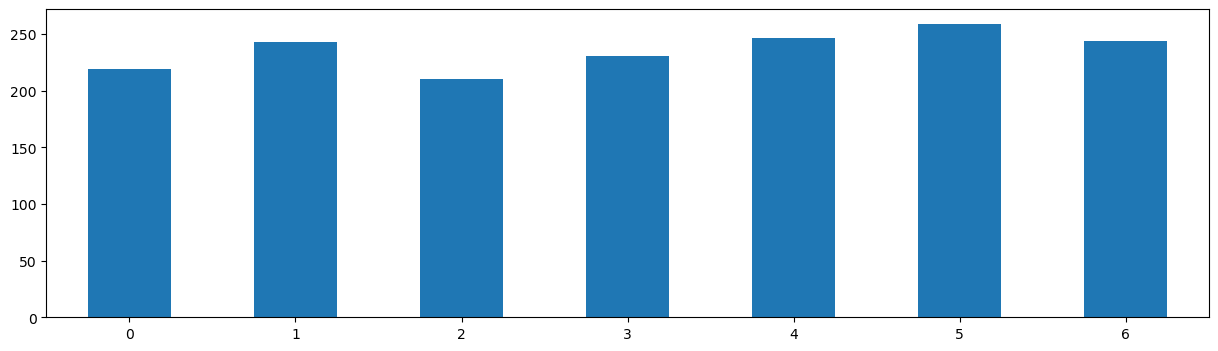

In [82]:
pd.to_datetime(df_date).dt.weekday.value_counts().sort_index().plot.bar(figsize=(15, 4), rot=0)

<AxesSubplot:>

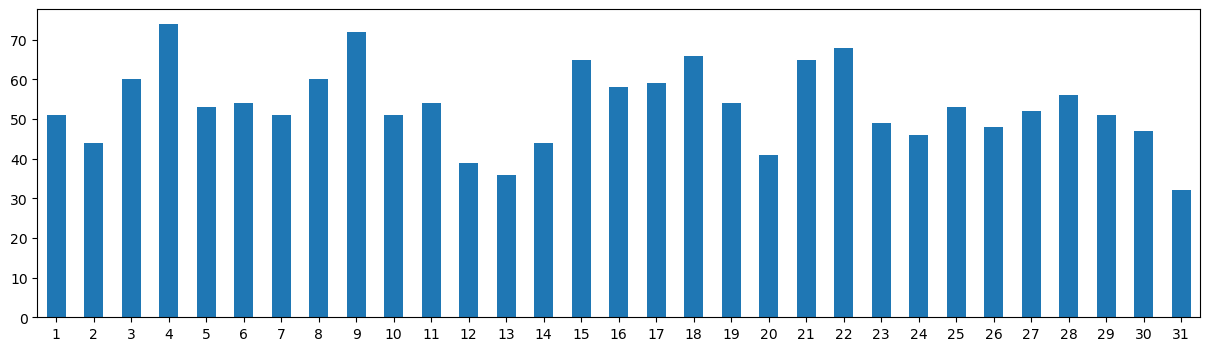

In [83]:
pd.to_datetime(df_date).dt.day.value_counts().sort_index().plot.bar(figsize=(15, 4), rot=0)